In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
from torch.utils.data import DataLoader

from evaluate.load.helpers import *
from evaluate.load.dataset import *
from evaluate.pipeline.model import *
from evaluate.pipeline.trainer import *
from evaluate.pipeline.embedding import *

In [2]:
def get_param(mode="paper",isHashEmbedding=True):
    return {"use_hash_embeddings": isHashEmbedding,
            "hashing_trick": True,
            "ngram_range": (1,9),
            "nFeaturesRange": (4,100),
            "embedding_size": 20,
            "num_buckets": 10**6,
            "max_features": 10**7,
            "max_epochs": 100,
            "num_hash_functions": 2,
            "hidden": 50,
            "seed": 123,
            "batch_size": 32,
            "masking":True,
            "append_weight":False,
            "validation_size":0.05,
            "patience":10,
            'cuda':True,
            'num_workers':4}
            
param = get_param()
seed = param['seed']
max_features = param['max_features']
ngram_range = param['ngram_range']
use_hash_embeddings = param['use_hash_embeddings']
isHashingTrick = param['hashing_trick']
num_buckets = param['num_buckets']
embedding_size = param['embedding_size']
max_epochs = param['max_epochs']
masking = param['masking']
append_weight = param['append_weight']
patience = param['patience']
num_hash_functions = param['num_hash_functions']
batch_size = param['batch_size']
validation_size = param['validation_size']
nFeaturesRange = param['nFeaturesRange']
isCuda = param['cuda']
num_workers = param['num_workers']

In [3]:
isHashingTrick = False

In [4]:
v=Vocabulary(num_words=5,ngramRange=(1,3))

In [5]:
v.fit('hello my name is yes yann yes yann')

In [6]:
list(v.tokenize('hello my name is yes yann yes yann'))

[4, 5, 1, 2, 1, 2, 3, 3]

In [10]:
v['yes yann']

3

In [15]:
list(v.fit_tokenize('hello my name is yes yann yes yann'))

[1, 2, 3, 4, 5, 6, 5, 6, 7, 8, 9, 10, 11, 12, 11]

In [11]:
%%time

np.random.seed(seed)
torch.manual_seed(seed)

if isHashingTrick:
    train = AgNews(nFeaturesRange=nFeaturesRange,train=True,ngramRange=ngram_range,isHashingTrick=True,seed=seed)
    test = AgNews(nFeaturesRange=nFeaturesRange,train=False,ngramRange=ngram_range,isHashingTrick=True,seed=seed)
else:
    train = AgNews(nFeaturesRange=nFeaturesRange,num_words=max_features,train=True,ngram_range=ngram_range,isHashingTrick=False,seed=seed)
    test = AgNews(nFeaturesRange=nFeaturesRange,num_words=max_features,train=False,ngram_range=ngram_range,isHashingTrick=False,seed=seed,trainVocab=train.vocab)

TypeError: __init__() got an unexpected keyword argument 'ngram_range'

In [ ]:
#train, valid = train_valid_load(train,validSize=0.1,isShuffle=True,seed=123,batch_size=batchSize)
test = DataLoader(dataset=test,batch_size=batch_size,shuffle=True)

In [6]:
train.label


 2
 2
 2
⋮ 
 1
 1
 1
[torch.LongTensor of size 120000]

In [7]:
train.labels = train.label

In [9]:
for x,y in DataLoader(dataset=train,batch_size=batch_size,shuffle=True):
    print(x.shape)
    print(y.shape)
    print(x)
    break

torch.Size([32, 1348])
torch.Size([32])

-5.9271e+18  1.4534e+18 -6.6569e+17  ...   0.0000e+00  0.0000e+00  0.0000e+00
 1.3309e+18  6.5815e+18  4.9286e+18  ...   0.0000e+00  0.0000e+00  0.0000e+00
 8.4722e+18  4.4392e+18 -3.4756e+18  ...   0.0000e+00  0.0000e+00  0.0000e+00
                ...                   ⋱                   ...                
 5.5544e+18 -6.2125e+18 -7.9083e+18  ...   0.0000e+00  0.0000e+00  0.0000e+00
-3.4780e+18  8.9662e+18  3.9883e+18  ...   0.0000e+00  0.0000e+00  0.0000e+00
 2.6035e+18  1.1896e+18  9.0944e+18  ...   0.0000e+00  0.0000e+00  0.0000e+00
[torch.LongTensor of size 32x1348]



In [ ]:
torch.LongTensor()

In [24]:
num_classes = len(train.classes)
model = ModelNoDict(max_features,embedding_size,num_classes,isHash=True,append_weight=True,num_buckets=num_buckets)
if isCuda:
    model.cuda
trainer = Trainer(model,seed=seed)
callbacks = [EarlyStopping(patience=patience)]

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

In [5]:
from collections import Counter

In [19]:
c=Counter(['test','are','are'])

In [20]:
c

Counter({'are': 2, 'test': 1})

In [21]:
c.update(iter(['is','are']))

In [22]:
c

Counter({'are': 3, 'is': 1, 'test': 1})

In [146]:
def n_grams(listTokens, n):
    shiftedTokens = (listTokens[i:] for i in range(n))
    tupleNGrams = zip(*shiftedTokens)
    return (" ".join(i) for i in tupleNGrams)

In [147]:
def range_ngrams(listTokens, ngram_range):
    return chain(*(n_grams(listTokens, i) for i in range(*ngram_range)))

In [148]:
from itertools import chain

In [149]:
input_list = ['all', 'this', 'happened', 'more', 'or', 'less']

list(range_ngrams(input_list, (1,4)))

['all',
 'this',
 'happened',
 'more',
 'or',
 'less',
 'all this',
 'this happened',
 'happened more',
 'more or',
 'or less',
 'all this happened',
 'this happened more',
 'happened more or',
 'more or less']

In [91]:
" ".join(('all', 'this'))

'all this'

In [63]:
list(zip(*((el for j,el in enumerate(it) if j>=i) for i in range(2))))

[]

In [82]:
for a,b in find_ngrams(['hey','how','are','you'], 2):
    print (a,b)

ValueError: too many values to unpack (expected 2)

In [48]:
for i in ['hey','how','are','you']:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-48-f6eeef96d2ec>, line 1)

In [30]:
%%time
trainer(train,callbacks=callbacks,validSize=validation_size,num_workers=num_workers,epochs=max_epochs)

Num parameters in model: 400092
Train on 3563 samples, validate on 188 samples
Epoch: 0. Loss: 0.2861010432243347. Acc: 0.8556666666666667.
Stoping at epoch:12 with patience:10. Best:0.8655.
CPU times: user 53.5 s, sys: 840 ms, total: 54.3 s
Wall time: 54.6 s


In [6]:
%%time
trainer(train,callbacks=callbacks,validSize=validation_size)

Num parameters in model: 40000092
Train on 3563 samples, validate on 188 samples
Epoch: 0. Loss: 0.533701479434967. Acc: 0.7716666666666666.
Epoch: 1. Loss: 0.24999885261058807. Acc: 0.782.
Epoch: 2. Loss: 0.13356901705265045. Acc: 0.794.
Epoch: 3. Loss: 0.20342786610126495. Acc: 0.7993333333333333.
Epoch: 4. Loss: 0.34462618827819824. Acc: 0.7976666666666666.
Epoch: 5. Loss: 0.09012521803379059. Acc: 0.7925.
Epoch: 6. Loss: 0.14708219468593597. Acc: 0.7915.


KeyboardInterrupt: 

In [7]:
num_classes = len(train.classes)
model = ModelNoDict(max_features,embedding_size,num_classes,isHash=False,num_buckets=num_buckets)
trainer = Trainer(model)
callbacks = [EarlyStopping(patience=param['patience'])]

In [8]:
%%time
trainer(train,callbacks=callbacks,validSize=validation_size)

Num parameters in model: 200000084
Train on 3563 samples, validate on 188 samples


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [21]:
input_list = 'test the ngrams'*10

In [19]:
print(list(range_ngrams(input_list, ngramRange=(1,4))))

[('test',), ('the',), ('ngrams',), ('generator',), ('test', 'the'), ('the', 'ngrams'), ('ngrams', 'generator'), ('test', 'the', 'ngrams'), ('the', 'ngrams', 'generator')]


In [11]:
from itertools import chain

def n_grams(seq, n=1):
    """Returns an itirator over the n-grams given a listTokens"""
    shiftToken = lambda i: (el for j,el in enumerate(seq) if j>=i)
    shiftedTokens = (shiftToken(i) for i in range(n))
    tupleNGrams = zip(*shiftedTokens)
    return tupleNGrams # if join in generator : (" ".join(i) for i in tupleNGrams)

def range_ngrams(listTokens, ngramRange=(1,2)):
    """Returns an itirator over all n-grams for n in range(ngramRange) given a listTokens."""
    return chain(*(n_grams(listTokens, i) for i in range(*ngramRange)))

In [13]:
print(list(range_ngrams(input_list, ngramRange=(1,3))))

[('all',), ('this',), ('happened',), ('more',), ('or',), ('less',), ('all', 'this'), ('this', 'happened'), ('happened', 'more'), ('more', 'or'), ('or', 'less')]


In [64]:
import nltk

In [77]:
%%timeit
input_list = 'test the ngrams interator vs nltk '*10**6
nltk.ngrams(input_list,n=1)
nltk.ngrams(input_list,n=2)
nltk.ngrams(input_list,n=3)
nltk.ngrams(input_list,n=4)
nltk.ngrams(input_list,n=5)

7.32 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [78]:
%%timeit
input_list = 'test the ngrams interator vs nltk '*10**6
range_ngrams(input_list, ngramRange=(1,6))

7.18 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
%%time
trainer(train,callbacks=callbacks,validSize=0.1)

Num parameters in model: 2000084
Train on 3375 samples, validate on 375 samples
Epoch: 0. Loss: 0.16543151438236237. Acc: 0.9149166666666667.
Epoch: 1. Loss: 0.2636685371398926. Acc: 0.9113333333333333.
Epoch: 2. Loss: 0.11431225389242172. Acc: 0.90375.
Stoping at epoch:2 with patience:2. Best:0.9149166666666667.
CPU times: user 5min 55s, sys: 1.13 s, total: 5min 56s
Wall time: 5min 57s


In [22]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.init import normal

class HashEmbedding(nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, num_buckets=None, num_hashes=2, train_sharedEmbed=True,
                 train_weight=True, append_weight=True, aggregation_mode='sum', mask_zero=False,seed=None):
        super(HashEmbedding, self).__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.num_hashes = num_hashes
        defaultNBuckets = (num_embeddings * self.num_hashes)//(self.embedding_dim)
        self.num_buckets = num_buckets - 1 if num_buckets is not None else defaultNBuckets
        self.train_sharedEmbed = train_sharedEmbed
        self.train_weight = train_weight
        self.append_weight = append_weight
        self.padding_idx = 0 if mask_zero else None
        self.seed = seed
        
        self.importance_weights = nn.Embedding(self.num_embeddings,
                                              self.num_hashes)
        self.shared_embeddings = nn.Embedding(self.num_buckets + 1,
                                            self.embedding_dim,
                                            padding_idx=self.padding_idx)
        self.hashes = None
        
        if aggregation_mode == 'sum':
            self.aggregate = lambda x: torch.sum(x, dim=-1)
        elif aggregation_mode == 'concatenate':
            # little bit quicker than permute/contiguous/view
            self.aggregate = lambda x: torch.cat([x[:,:,:,i] for i in range(self.num_hashes)], dim=-1) 
        elif aggregation_mode == 'mean':
            self.aggregate = lambda x: torch.mean(x, dim=-1)
        else:
            raise ValueError('unknown aggregation function {}'.format(aggregation_mode))
        
        self.output_dim = self.embedding_dim 
        if aggregation_mode == "concatenate":
            self.output_dim *= self.num_hashes
        if self.append_weight:
            self.output_dim += self.num_hashes
            
        self.reset_parameters()   
        
    def reset_parameters(self,
                        init_shared=lambda x: normal(x,std=0.1),
                        init_importance=lambda x: normal(x,std=0.0005)):
        """Resets the trainable parameters."""
        def set_constant_row(parameters,iRow=0,value=0):
            """Return `parameters` with row `iRow` as s constant `value`."""
            data = parameters.data
            data[iRow,:] = value
            return torch.nn.Parameter(data,requires_grad=parameters.requires_grad)

        np.random.seed(self.seed)
        if self.seed is not None:
            torch.manual_seed(self.seed)

        self.shared_embeddings.weight = init_shared(self.shared_embeddings.weight)
        self.importance_weights.weight = init_importance(self.importance_weights.weight)

        if self.padding_idx is not None:
            # Unfortunately has to set weight to 0 even when paddingIdx = 0
            self.shared_embeddings.weight = set_constant_row(self.shared_embeddings.weight)
            self.importance_weights.weight = set_constant_row(self.importance_weights.weight)

        self.shared_embeddings.weight.requires_grad = self.train_sharedEmbed
        self.importance_weights.weight.requires_grad = self.train_weight

        self.hashes = torch.from_numpy((np.random.randint(0, 2 ** 30,
                                                          size=(self.num_embeddings, self.num_hashes)
                                                         ) % self.num_buckets) + 1 
                                      ).type(torch.LongTensor)
        
    def _idx_hash(self, inputs, maxOutput, mask_zero=True):
        r"""Hash function for integers used to map indices of different sizes.
        
        Args:
            inputs (torch.Tensor): indices to hash.
            maxOutput (int): maximum integer to output. I.e size of table to access.
            mask_zero (bool,optional): whether should only map zero input to zero.
            
        To Do:
            Should enable :math:`\hat{D} \neq D_1`.
        """  
        if mask_zero:
            idx_zero = inputs == 0
            # shouldn't map non zero vectors to 0
            inputs = inputs%(maxOutput-1) + 1
            inputs[idx_zero] = 0
            return inputs
        else:
            return inputs%maxOutput
            
    def forward(self, input):  
        idx_hashes = self._idx_hash(input,self.num_embeddings,mask_zero=self.padding_idx is not None)
        idx_importance_weights = self._idx_hash(input,self.num_embeddings,mask_zero=False)
        idx_shared_embeddings = self.hashes[idx_hashes.data.cpu(),:]
        
        shared_embedding = torch.stack([self.shared_embeddings(idx_shared_embeddings[:,:,iHash]) 
                                        for iHash in range(self.num_hashes)], dim=-1)
        importance_weight = self.importance_weights(idx_importance_weights)
        importance_weight = importance_weight.unsqueeze(-2)
        word_embedding = self.aggregate(importance_weight*shared_embedding)
        if self.append_weight:
            # concateates the vector with the weights
            word_embedding = torch.cat([word_embedding,importance_weight.squeeze(-2)],dim=-1) 
        return word_embedding
    

In [24]:
h=HashEmbedding(10,3,5,2)

In [25]:
h.hashes


    2     3
    4     3
    4     4
    1     1
    4     1
    1     2
    1     1
    2     3
    1     4
    1     3
[torch.LongTensor of size 10x2]

In [27]:
l=[lambda x : 2*x,lambda x : 3*x]

In [ ]:
61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139,
    149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227,
    229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311,
    313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401,
    409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491,
    499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599,
    601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683,
    691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797,
    809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887,
    907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997)


In [ ]:
 1, 11, 13, 17, 19, 23, 29, 31, 37, 41,
   43, 47, 53, 59, 61, 67, 71, 73, 79, 83,
   89, 97,101,103,107,109,113,121,127,131,
  137,139,143,149,151,157,163,167,169,173,
  179,181,187,191,193,197,199,209

In [164]:
is_prim(100000007)

In [168]:
def next_prime(n):
    def is_prime(x):
        for i in range(2,int(np.sqrt(x))):
            if x % i == 0:
                return False
        return True
            
    while not is_prime(n):
        n += 1
    
    return n
        

In [171]:
next_prime(10**8)

100000007

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
def universal_hashes(a,b,p=199,m=127):
    return lambda x: ((a*x+b)%p)%m

In [190]:
n = 10**2

p=next_prime(n*np.random.randint(10000))
m=next_prime(n)
m=n
print(p,m)
a = np.random.randint(1,p)
b = np.random.randint(0,p)
h1 = universal_hashes(a,b,p=p,m=m)
print(a,b)
a = np.random.randint(1,p)
b = np.random.randint(0,p)
h2 = universal_hashes(a,b,p=p,m=m)
print(a,b)

786803 100
387521 26976
273270 124644


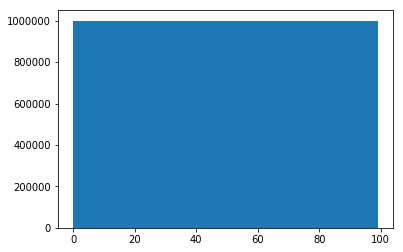

In [191]:
arr1 = np.array([h1(i) for i in range(10**7)])
_=plt.hist(arr1)

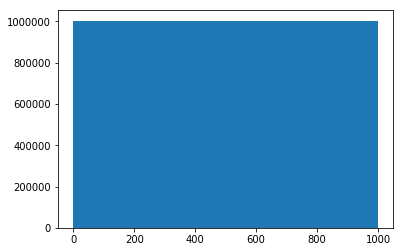

In [185]:
arr2 = np.array([h2(i) for i in range(10**7)])
_=plt.hist(arr2)

In [179]:
Counter(arr1)

Counter({27311: 101,
         34893: 101,
         42475: 101,
         50057: 101,
         57639: 101,
         65221: 101,
         72803: 101,
         80385: 101,
         87967: 101,
         95549: 101,
         3128: 101,
         10710: 101,
         18292: 101,
         25874: 101,
         33456: 101,
         41038: 101,
         48620: 101,
         56202: 101,
         63784: 101,
         71366: 101,
         78948: 101,
         86530: 101,
         94112: 101,
         1717: 100,
         9299: 100,
         16881: 100,
         24463: 100,
         32045: 100,
         39627: 100,
         47209: 100,
         54791: 100,
         62373: 100,
         69955: 100,
         77537: 100,
         85119: 100,
         92701: 100,
         280: 100,
         7862: 100,
         15444: 100,
         23026: 100,
         30608: 100,
         38190: 100,
         45772: 100,
         53354: 100,
         60936: 100,
         68518: 100,
         76100: 100,
         83682: 100